# Sepsis Classification ML Project

## Business Understanding
Sepsis is a life-threatening medical emergency caused by the body's extreme reaction to an infection. It happens when an infection you already have triggers an adverse chain reaction throughout your body. Timely treatment of an underlying infection is important because sepsis rapidly leads to tissue damage, organ failure, and death. Early examination of patients test results by medical practitioners aids to determine those susceptible of developing sepsis and subsequent treatment. I endeavor to create a ML model that can predict likelihood of patients developing sepsis based on various test features, enabling a proactive approach to treatment if diagnosed as positive. Developed ML pipeline will require patient test attributes as input and predicted output will be positive or negative diagnosis for sepsis.

### Hypothesis
Null: There is no significant relationship between patient age and developing sepsis

Alternate: There is significant relationship between between patient age and developing sepsis


## Data Understanding
The features of the dataset are as outlined below. The dataset has 8 attributes and the target is sepsis.
**ID** : number to represent patient ID

**PRG** : Plasma glucose

**PL**: Blood Work Result-1 (mu U/ml)

**PR**: Blood Pressure (mm Hg)

**SK**: Blood Work Result-2 (mm)

**TS**: Blood Work Result-3 (mu U/ml)

**M11**: Body mass index (weight in kg/(height in m)^2)

**BD2**: Blood Work Result-4 (mu U/ml)

**Age**: patients age (years)

**Insurance**: If a patient holds a valid insurance card

**Sepsis**: **Positive**: if a patient in ICU will develop a sepsis , and **Negative**: otherwise.

### Business questions

1. What is the distribution of sepsis cases?

2. what is the relationship of insurance and sepsis? What's the distribution of insurance cover amongst patients?

3. How does Blood Pressure, Body mass Index, and Plasma glucose influence sepsis? Are patients with high Blood Pressure and Body mass Index likely to develop sepsis?

4. What is the relationship of age to sepsis? Which age is most likely to be affected by sepsis?

### Importation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, KFold
#Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats

#metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import pickle

import warnings
warnings.filterwarnings("ignore")

### Loading

In [2]:
train_df = pd.read_csv("..\datasets\Patients_Files_Train.csv")
test_df = pd.read_csv("..\datasets\Patients_Files_Test.csv")

In [3]:
# Preview of first five rows in the datasets using pandas .head() method

#A. train dataset
train_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [4]:
# B. test dataset
test_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [5]:
# Any missing values in the datasets? 

print("Count of Missing values")
print("**" * 13)
print(f'Missing values in train dataset:', train_df.isna().any().sum())
print(f'Missing values in test dataset:', test_df.isna().any().sum())

#There are no missing values in both train and test datasets

Count of Missing values
**************************
Missing values in train dataset: 0
Missing values in test dataset: 0


In [6]:
# Any duplicate values in the columns of the datasets? 

print("Count of Duplicate values")
print("**" * 13)
print(f'Duplicate values in train dataset:', train_df.duplicated().sum())
print(f'Duplicate values in test dataset:', test_df.duplicated().sum())

#There are no duplicate values in both train and test datasets

Count of Duplicate values
**************************
Duplicate values in train dataset: 0
Duplicate values in test dataset: 0


In [7]:
#Information summary on train dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [8]:
# statistical summary of numerical columns of train dataset
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


# EDA 

## Univariate analysis

1. What is the distribution of sepsis cases?

In [9]:
#Distribution of Sepsis

sepsis_count = train_df['Sepssis'].value_counts()
sepsis_count 

Sepssis
Negative    391
Positive    208
Name: count, dtype: int64

The dataset is unbalanced with "Negative" sepsis cases being more compared to the "Positive" sepsis cases

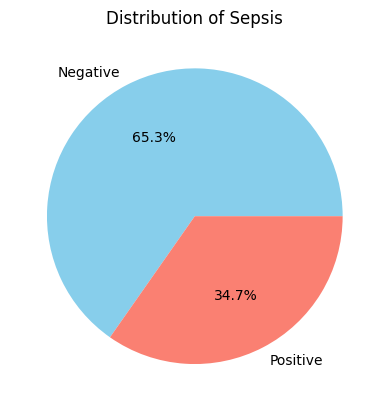

In [10]:
#Visualization of Distribution of Sepsis


plt.pie(sepsis_count, labels=sepsis_count.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title("Distribution of Sepsis")
plt.show()

Distribution of Insurance

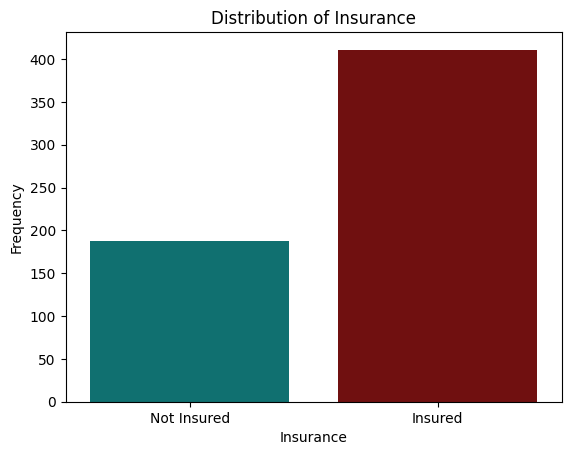

In [11]:
#Distribution of Insurance 

label = {0: "Not Insured", 1: "Insured"}

sns.countplot(data=train_df, x='Insurance', palette=['teal', 'maroon'])
plt.title("Distribution of Insurance")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=label.values())  # Set the ticks and labels using the 'label' dictionary
plt.show()

Majority of patients have health insurance cover in comparison to those without health insurance cover

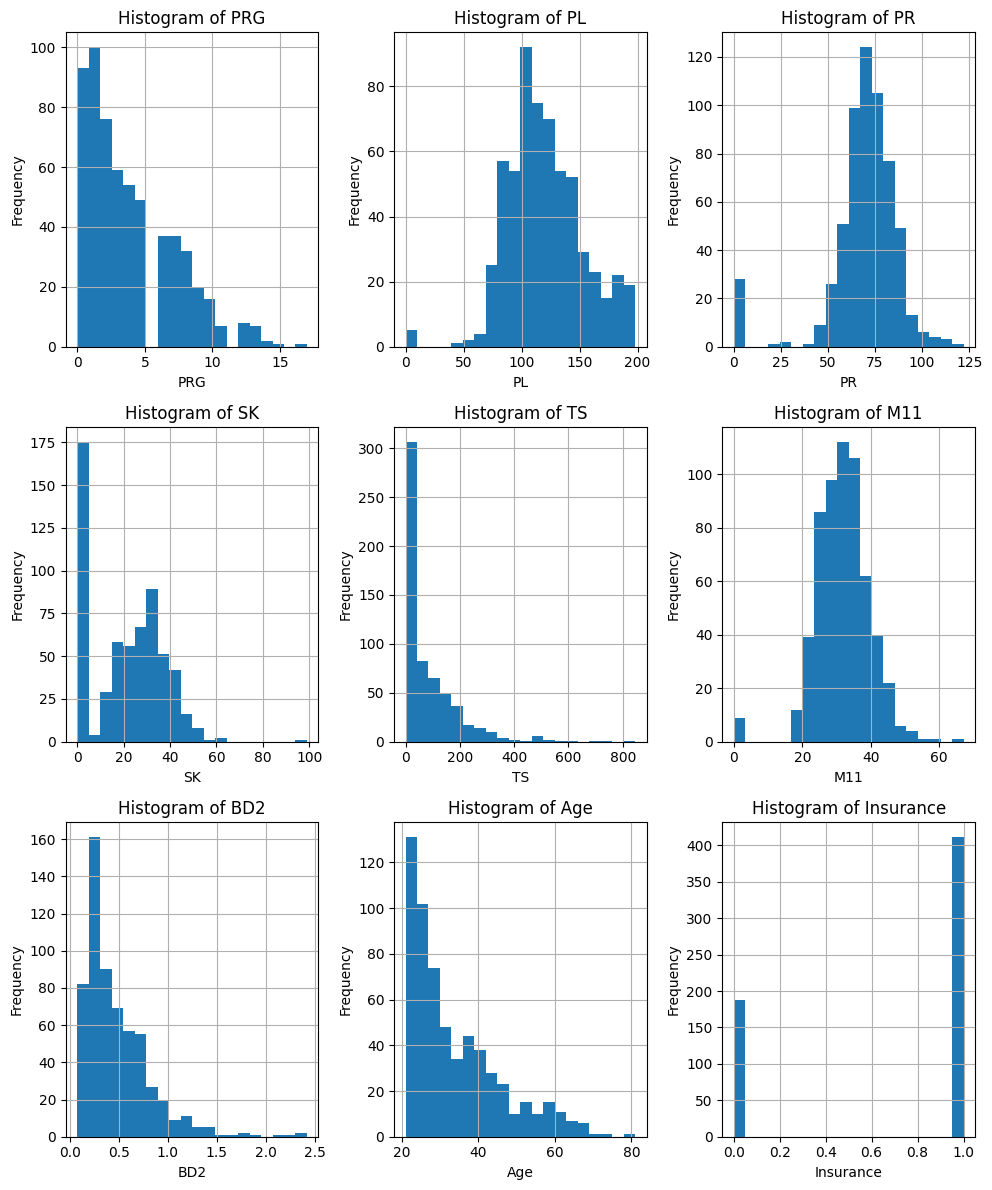

In [12]:
#Distribution and comparison of different variables

cols = ["PRG", "PL", "PR", "SK", "TS", "M11", "BD2", "Age", "Insurance"]
num_cols = len(cols)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 12))  # Adjust the size and layout as needed

for i, column in enumerate(cols):
    ax = axes[i // 3, i % 3]  # Get the corresponding subplot axes
    train_df[column].hist(bins=20, ax=ax)  # Plot histogram for each column
    ax.set_title(f'Histogram of {column}')  # Set subplot title
    ax.set_xlabel(column)  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

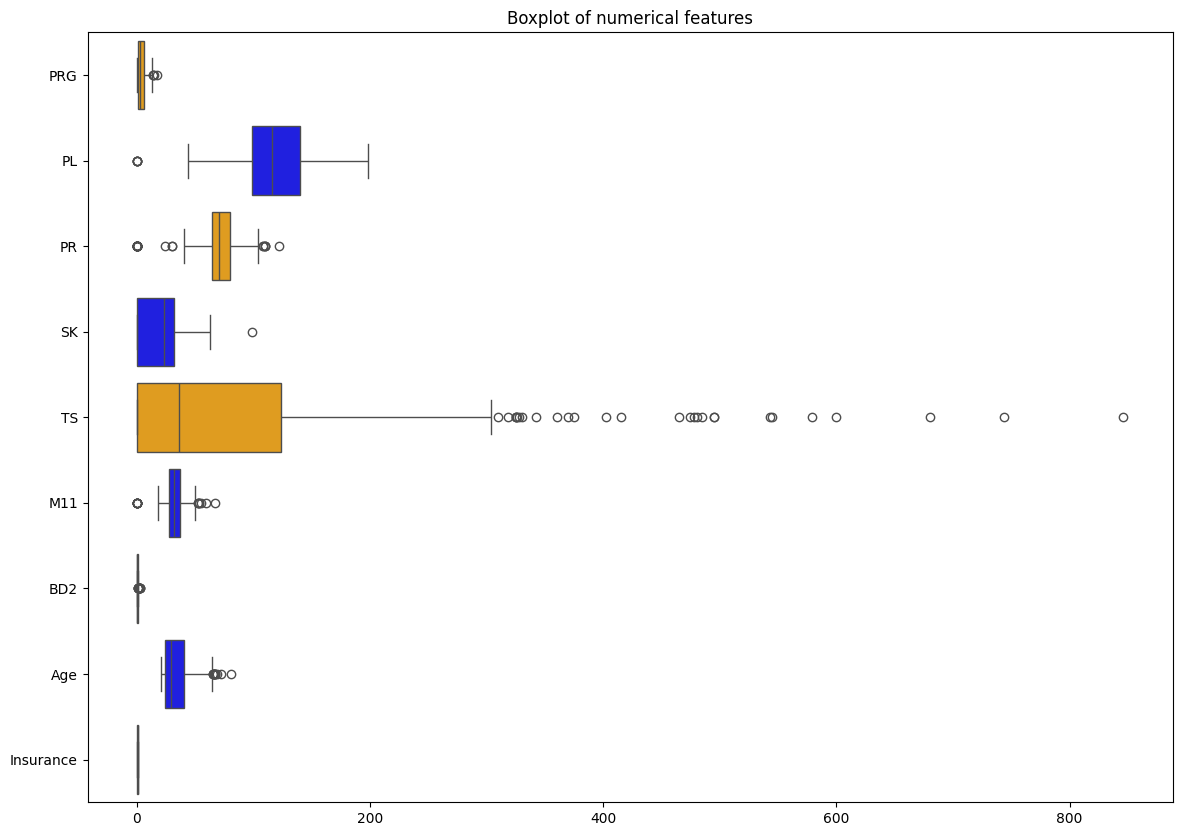

In [13]:
#Plotting of  Boxplots to show outliers
fig, ax = plt.subplots(figsize=(14, 10))
sns.boxplot(train_df[cols], whis=1.5, orient = 'h', palette = ['orange', 'blue'])
plt.title('Boxplot of numerical features')
plt.show()

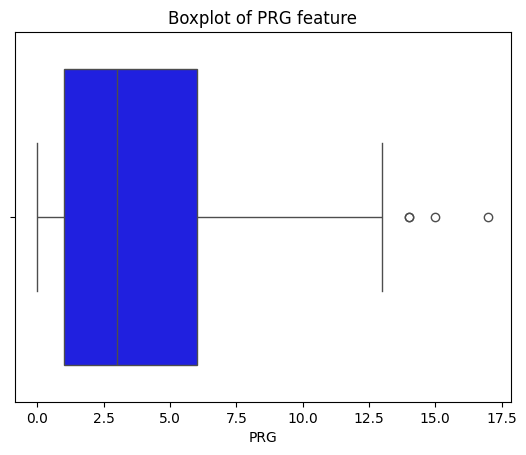

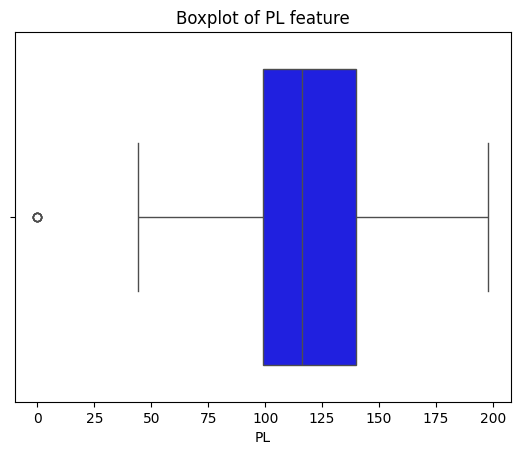

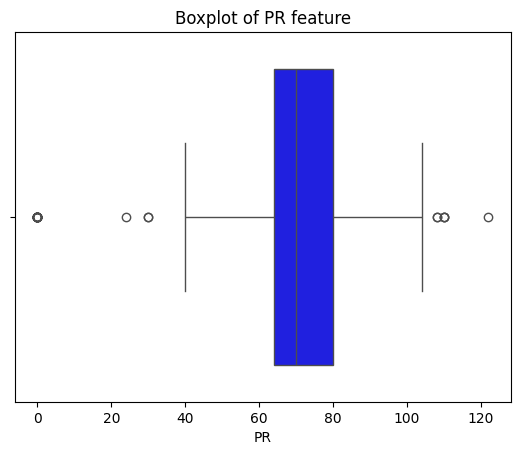

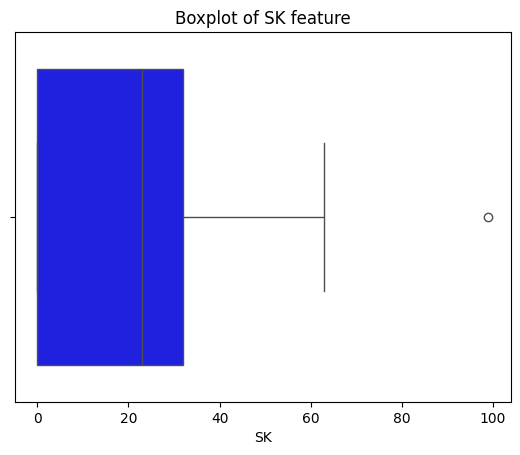

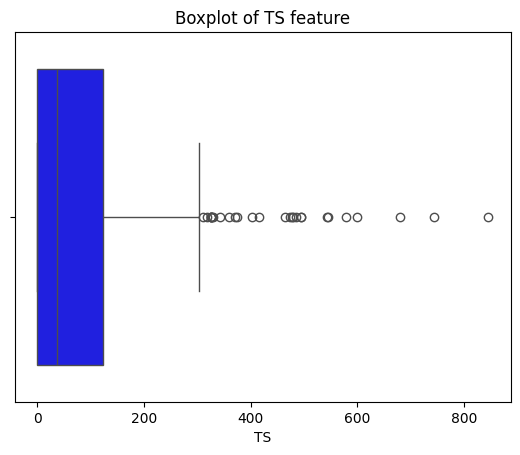

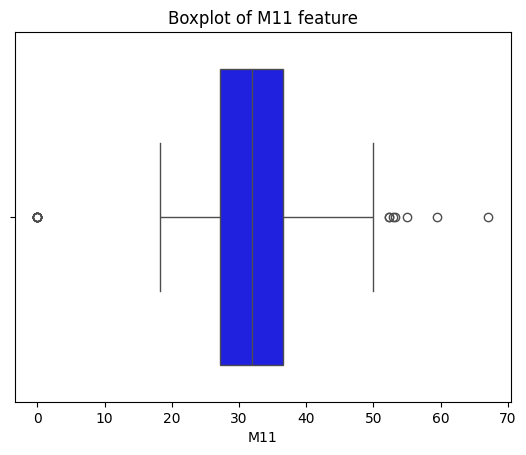

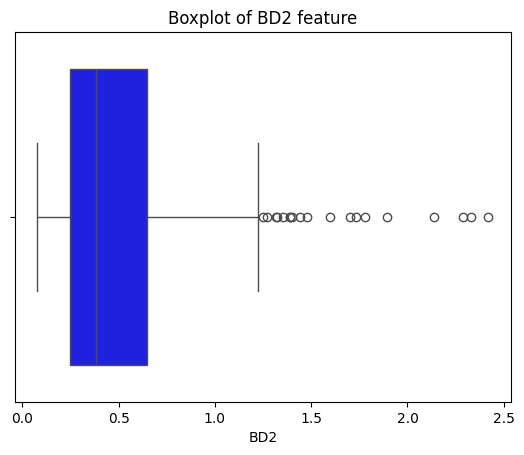

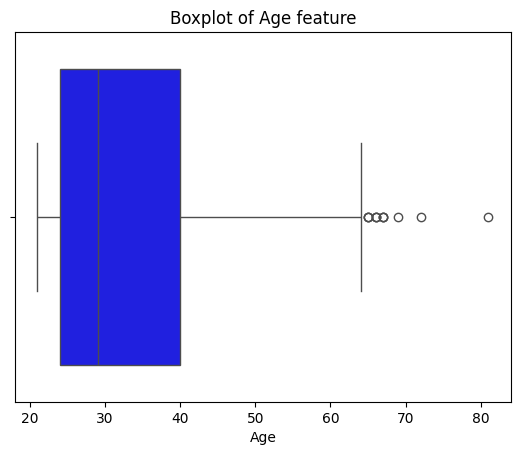

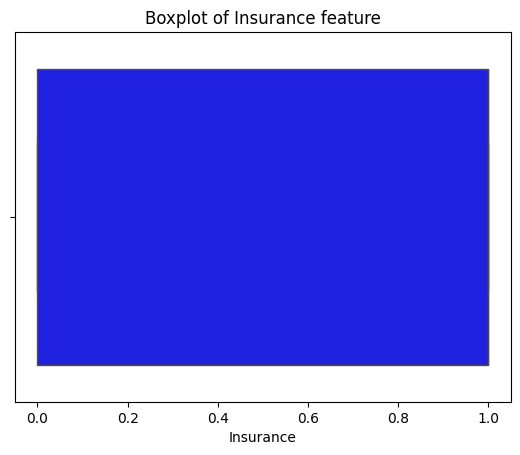

In [14]:
for var in cols:
    sns.boxplot(train_df[var], whis=1.5, orient = 'h', palette = ['blue'])
    plt.title(f'Boxplot of {var} feature')
    plt.show()

## Bivariate Analysis

What is the relationship of age to sepsis? Which age is most likely to be affected by sepsis?

In [15]:
# Feature-engineered 'Age-Group' column

bins = [20, 30, 40, 50, 100]
labels = ['20-30 years','30-40 years','40-50years', '50 + years']


train_df['Age_Group'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=True)

train_df['Age_Group'].value_counts()

Age_Group
20-30 years    323
30-40 years    128
40-50years      81
50 + years      67
Name: count, dtype: int64

Text(0, 0.5, 'Count')

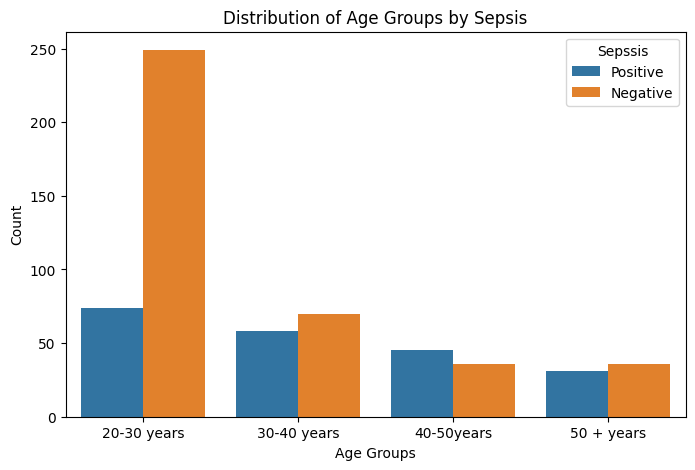

In [16]:
#Visualization of distribution of age groups by sepsis

plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Age_Group', hue='Sepssis')
plt.title('Distribution of Age Groups by Sepsis')
plt.xlabel('Age Groups')
plt.ylabel('Count')

Sepsis condition is greatly likely to affect those who are aged between 40 years and above. Those aged 20 - 30 years are less susceptible to contract sepsis in comparison to the other age groups.

What is the relationship of insurance and sepsis? What's the distribution of insurance cover amongst patients?

In [17]:
# Distribution of sepsis cases based on insurance cover

with_insurance_cover = train_df.groupby('Sepssis')['Insurance'].apply(lambda x: (x==1).sum())
without_insurance_cover = train_df.groupby('Sepssis')['Insurance'].apply(lambda x: (x==0).sum())

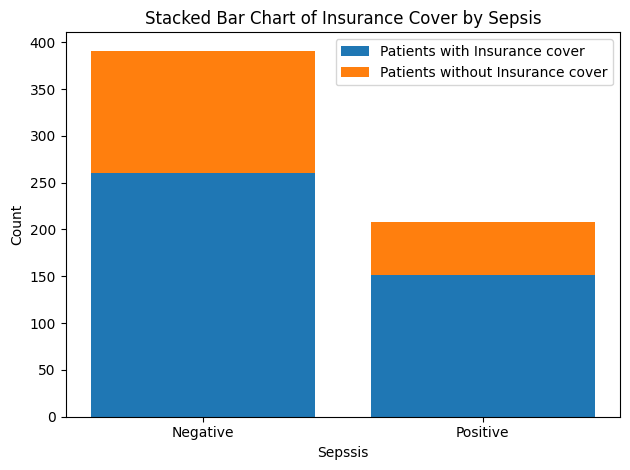

In [18]:
# Stacked bar chart
labels = with_insurance_cover.index  # index represents the categories
insured_patients = with_insurance_cover.values
uninsured_patients = without_insurance_cover.values

fig, ax = plt.subplots()

# Creating the bars
ax.bar(labels, insured_patients, label='Patients with Insurance cover')
ax.bar(labels, uninsured_patients, bottom=insured_patients, label='Patients without Insurance cover')

# Adding labels, title, and legend
ax.set_xlabel('Sepssis')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart of Insurance Cover by Sepsis')
ax.legend()

#plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


How does Blood Pressure, Body mass Index, and Plasma glucose influence sepsis? Are patients with high Blood Pressure and Body mass Index likely to develop sepsis?

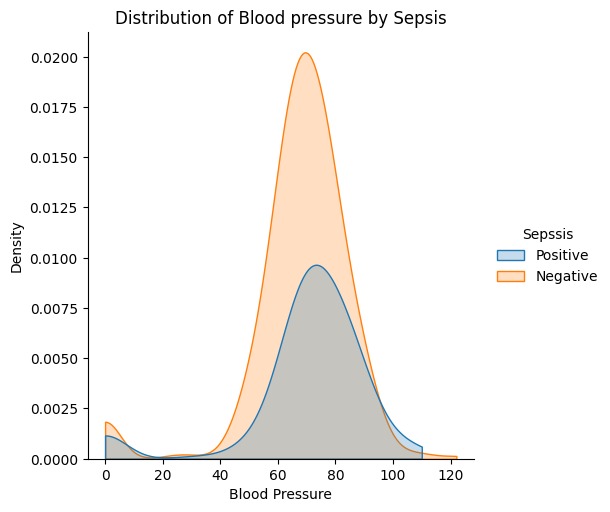

In [19]:
#Distribution of blood pressure by sepsis
sns.displot(train_df, x='PR', hue = 'Sepssis', kind='kde',cut=0, fill=True)
plt.title('Distribution of Blood pressure by Sepsis')
plt.xlabel('Blood Pressure');

Based on the plot, there is no direct relationship between high blood pressure and likelihood of developing sepsis by patients.

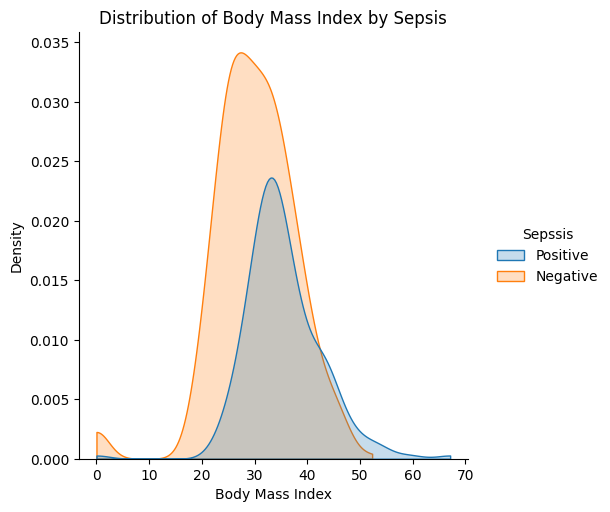

In [20]:
#Distribution of BMI by sepsis
sns.displot(train_df, x='M11', hue = 'Sepssis', kind='kde',cut=0, fill=True)
plt.title('Distribution of Body Mass Index by Sepsis')
plt.xlabel('Body Mass Index');

Patients with a Body Mass Index of above 25 have a higher chance of developing sepsis.

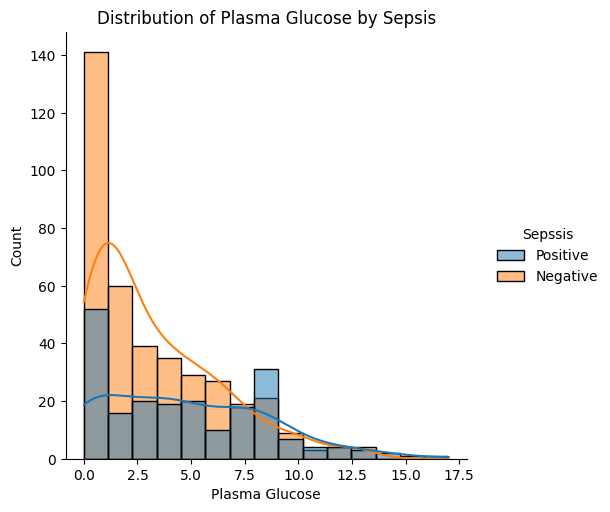

In [21]:
sns.displot(train_df, x='PRG', hue = 'Sepssis', kde=True,  fill=True)
plt.title('Distribution of Plasma Glucose by Sepsis')
plt.xlabel('Plasma Glucose');

There is no relationship between patients' plasma glucose levels and development of sepsis.

In [22]:
#convert target column 'sepsis' from object to an integer
# Feature-engineered 'sepsis-encoded' column

train_df['sepsis-encoded'] = train_df['Sepssis'].replace({"Negative" : 0 , "Positive": 1})

train_df['sepsis-encoded'].unique()

array([1, 0], dtype=int64)

In [23]:
train_df

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,Age_Group,sepsis-encoded
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive,40-50years,1
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative,30-40 years,0
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive,30-40 years,1
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative,20-30 years,0
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive,30-40 years,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative,30-40 years,0
595,ICU200605,0,188,82,14,185,32.0,0.682,22,1,Positive,20-30 years,1
596,ICU200606,0,67,76,0,0,45.3,0.194,46,1,Negative,40-50years,0
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative,20-30 years,0


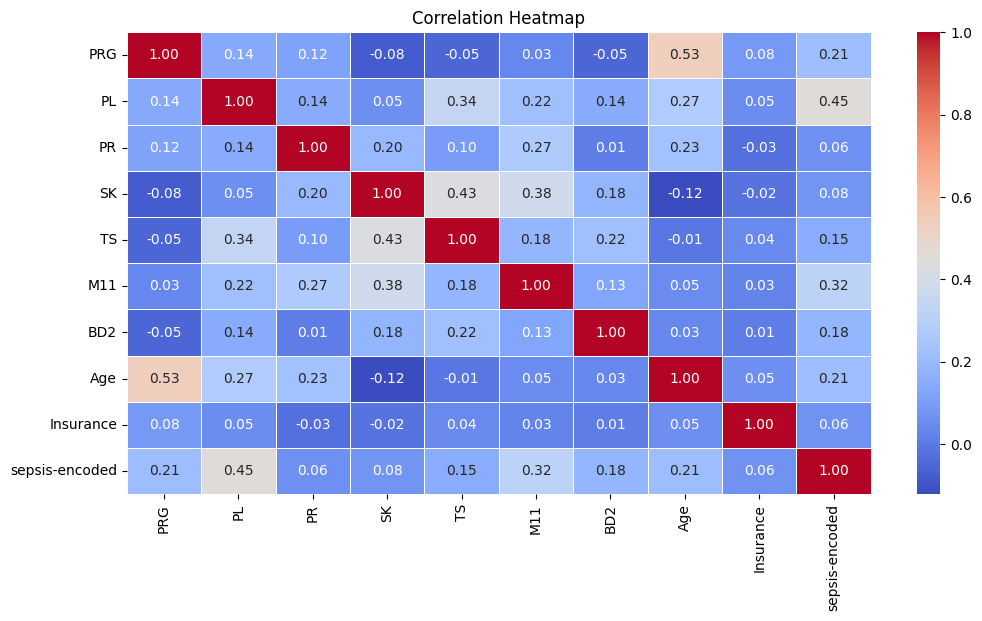

In [24]:
plt.figure(figsize=(12, 6))
# Drop non-numerical columns containing datatype object & category
correlation = train_df.drop(['ID', 'Age_Group', 'Sepssis'], axis=1).corr()

sns.heatmap(data=correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Hypothesis Testing

**Correlation Test: Pearson's correlation**

In [25]:
correlation, p_value = stats.pearsonr(train_df['Age'], train_df['sepsis-encoded'])

if p_value < 0.05: # Assuming Alpha level of 0.05
    print('There is a significant relationship patient age and developing sepsis.')
else:
    print('There is no significant relationship between patient age and developing sepsis.')

There is a significant relationship patient age and developing sepsis.


# Data Preparation

In [26]:
#Check on columns
train_df.columns

Index(['ID', 'PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance',
       'Sepssis', 'Age_Group', 'sepsis-encoded'],
      dtype='object')

In [27]:
# Drop columns that will not to be used
train_df = train_df.drop(columns=['ID', 'Age_Group', 'sepsis-encoded'], axis=1)

In [28]:
#Preview
train_df.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6,148,72,35,0,33.6,0.627,50,0,Positive
1,1,85,66,29,0,26.6,0.351,31,0,Negative
2,8,183,64,0,0,23.3,0.672,32,1,Positive
3,1,89,66,23,94,28.1,0.167,21,1,Negative
4,0,137,40,35,168,43.1,2.288,33,1,Positive


Remove outliers

In [29]:
# Create a copy of train dataframe to preserve original
train_c = train_df.copy()

#Define list of numerical features to be masked
numerical_features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

# Calculating the IQR (Interquartile Range)
Q1 = train_df[numerical_features].quantile(0.25)
Q3 = train_df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Creating a mask to identify outliers
outlier_mask = ((train_df[numerical_features] < (Q1 - 1.5 * IQR)) | (train_df[numerical_features] > (Q3 + 1.5 * IQR)))

# Removal of outliers
train_c = train_c[~outlier_mask.any(axis=1)]

#View of original and modified dataset
print(f'Original dataframe shape: {train_df.shape}')
print(f'dataframe shape after removing outliers: {train_c.shape}')

Original dataframe shape: (599, 10)
dataframe shape after removing outliers: (493, 10)


Define features & target variables 

In [30]:
# Define both features(X) and target (y) variables
X = train_c.drop('Sepssis', axis=1)
y = train_c['Sepssis']

Create a Pipeline

In [31]:
input_features = X.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), input_features),
        ('log_transformation', FunctionTransformer(np.log1p), input_features)
    ])

In [32]:
# Check of class distribution of target variable
print(f'Class distribution before balancing dataset:')
print(y.value_counts())

Class distribution before balancing dataset:
Sepssis
Negative    337
Positive    156
Name: count, dtype: int64


Balance dataset

In [33]:
#Use of SMOTE to generate synthetic values for the minority class
smote = SMOTE(random_state=40)
X_train_resampled , y_train_resampled = smote.fit_resample(X, y)

print(f'Class distribution after balancing dataset: \n {y_train_resampled.value_counts()}')


Class distribution after balancing dataset: 
 Sepssis
Positive    337
Negative    337
Name: count, dtype: int64


Data splitting into training & evaluation sets

In [34]:
# Split data ==> training set & evaluation set
X_train, X_eval, y_train, y_eval = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=40, stratify=y_train_resampled)

print(f'Shape of the training set (X_train, y_train): {X_train.shape, y_train.shape}\nShape of the evaluation set (X_eval, y_eval): {X_eval.shape, y_eval.shape}')

Shape of the training set (X_train, y_train): ((539, 9), (539,))
Shape of the evaluation set (X_eval, y_eval): ((135, 9), (135,))


In [35]:
# Encode the target variable
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_eval_encoded = encoder.transform(y_eval) 

# Modelling

In [36]:
# List of models for training process

models = [SVC(random_state=42), GaussianNB(), DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42),
           GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), LogisticRegression(random_state=42)]

metrics = []

# Iterating over models 
for model in models:
    # Create a pipeline containing the preprocesor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)

    # Predict using the evaluation set
    y_pred = pipeline.predict(X_eval)

    # Calculate the metrics
    accuracy = accuracy_score(y_eval_encoded, y_pred)
    f1 = f1_score(y_eval_encoded, y_pred)
    precision = precision_score(y_eval_encoded, y_pred)
    recall = recall_score(y_eval_encoded, y_pred)
    roc = roc_auc_score(y_eval_encoded, y_pred)

    # Append the metrics to the list

    metrics.append({'model':model.__class__.__name__,
                'Accuracy Score':accuracy,
                'F1 Score': f1,
                'precision_score': precision,
                'recall_score': recall,
                'ROC AUC Score': roc,})

#Create a Dataframe of model performance
model_performance = pd.DataFrame(metrics)
model_performance = model_performance.sort_values(by='Accuracy Score', ascending=False)
model_performance_styled = model_performance.style.background_gradient(cmap='tab10')
model_performance_styled

,model,Accuracy Score,F1 Score,precision_score,recall_score,ROC AUC Score
3,RandomForestClassifier,0.837037,0.840580,0.816901,0.865672,0.837248
4,GradientBoostingClassifier,0.814815,0.820144,0.791667,0.850746,0.815079
0,SVC,0.785185,0.778626,0.796875,0.761194,0.785009
1,GaussianNB,0.785185,0.778626,0.796875,0.761194,0.785009
5,AdaBoostClassifier,0.762963,0.768116,0.746479,0.791045,0.763169
6,LogisticRegression,0.740741,0.724409,0.766667,0.686567,0.740342
2,DecisionTreeClassifier,0.733333,0.735294,0.724638,0.746269,0.733428


model:  SVC
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        68
           1       0.80      0.76      0.78        67

    accuracy                           0.79       135
   macro avg       0.79      0.79      0.78       135
weighted avg       0.79      0.79      0.79       135



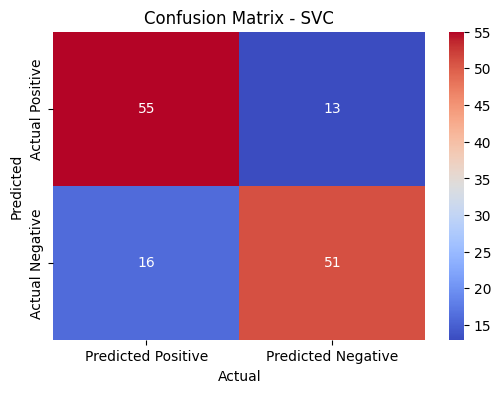

----------------------------------------------------------------------
model:  GaussianNB
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        68
           1       0.80      0.76      0.78        67

    accuracy                           0.79       135
   macro avg       0.79      0.79      0.78       135
weighted avg       0.79      0.79      0.79       135



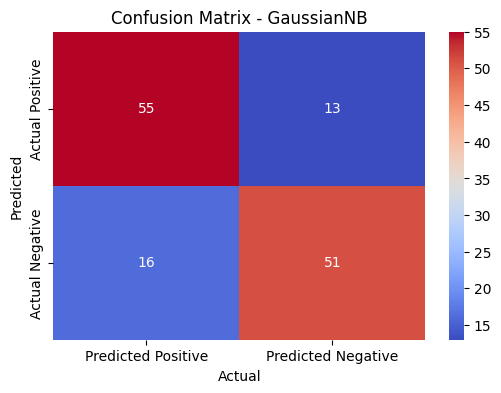

----------------------------------------------------------------------
model:  DecisionTreeClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.72      0.73        68
           1       0.72      0.75      0.74        67

    accuracy                           0.73       135
   macro avg       0.73      0.73      0.73       135
weighted avg       0.73      0.73      0.73       135



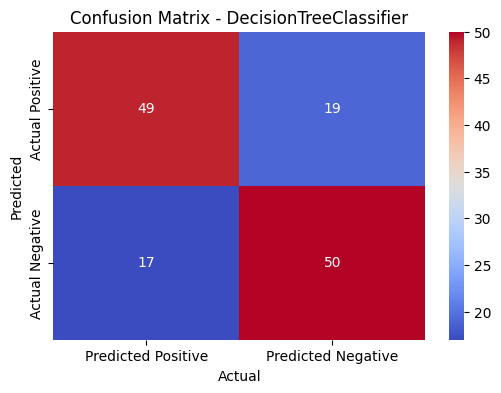

----------------------------------------------------------------------
model:  RandomForestClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        68
           1       0.82      0.87      0.84        67

    accuracy                           0.84       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.84      0.84      0.84       135



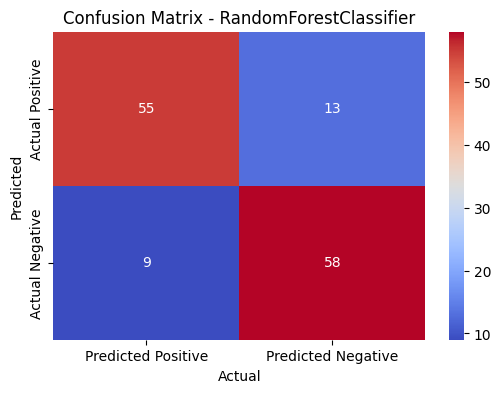

----------------------------------------------------------------------
model:  GradientBoostingClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81        68
           1       0.79      0.85      0.82        67

    accuracy                           0.81       135
   macro avg       0.82      0.82      0.81       135
weighted avg       0.82      0.81      0.81       135



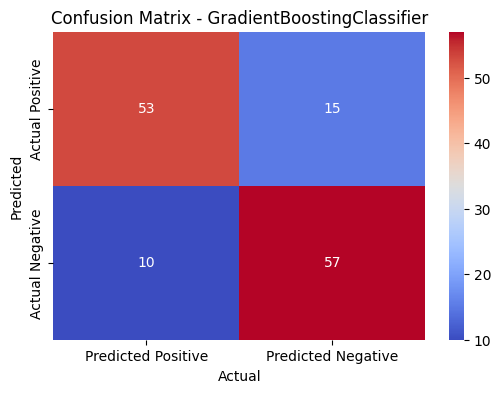

----------------------------------------------------------------------
model:  AdaBoostClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.74      0.76        68
           1       0.75      0.79      0.77        67

    accuracy                           0.76       135
   macro avg       0.76      0.76      0.76       135
weighted avg       0.76      0.76      0.76       135



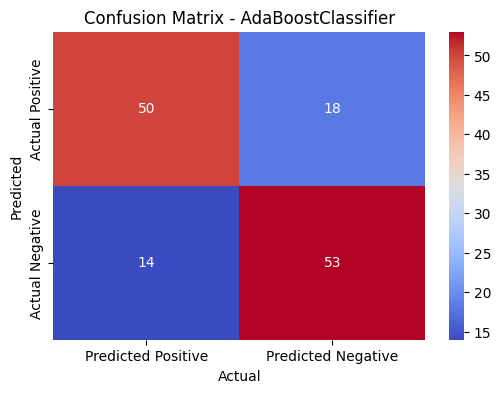

----------------------------------------------------------------------
model:  LogisticRegression
Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.79      0.76        68
           1       0.77      0.69      0.72        67

    accuracy                           0.74       135
   macro avg       0.74      0.74      0.74       135
weighted avg       0.74      0.74      0.74       135



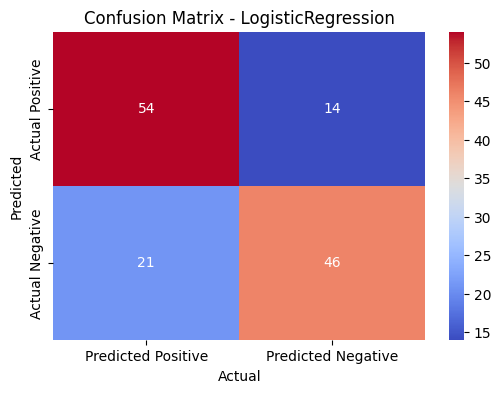

----------------------------------------------------------------------


In [37]:
models = [SVC(random_state=42), GaussianNB(), DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42),
           GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), LogisticRegression(random_state=42)]

metrics = []

# Iterating over models 
for model in models:
    # Create a pipeline containing the preprocesor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)

    # Predict using the evaluation set
    y_pred = pipeline.predict(X_eval)

    # print classification report
    print('model: ', model.__class__.__name__)
    print('Classification Report: \n', classification_report(y_eval_encoded, y_pred))

    #Generate and display confusion matrix
    conf_matrix = confusion_matrix(y_eval_encoded, y_pred)

        # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', 
                xticklabels=['Predicted Positive', 'Predicted Negative'], 
                yticklabels=['Actual Positive', 'Actual Negative'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

    print('--'*35)


### Hyperparameter Tuning

Fine-tune the Top-k models (2 < k <5) using a Gridsearchcv/Randomsearchcv (that is in sklearn.model_selection) to find the best hyperparameters and achieve the maximum performance of each of the Top-k models, then compare them again to select the best one.

Tuning of top 2 models

In [38]:
# List of final models to be finetuned.
final_models = [GradientBoostingClassifier(random_state=40), RandomForestClassifier(random_state=40)]

# List to store final models
final_models_finetuned =[]

Use of .get_params method to view model parameters

Model 1

Hyperparameter Tuning of GradientBoosting model 

In [39]:
final_models[0]

GradientBoostingClassifier(random_state=40)

In [40]:
final_models[0].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [41]:
# Define the parameter grid to search through
param_dist = {
    'loss': ['log_loss'],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [1, 2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 6],
    'subsample': [0.8, 0.9, 1.0]
}

# Create KFold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=1)


# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=final_models[0],
    param_distributions=param_dist,
    n_iter=10,     # Number of random combinations to try
    cv=kf,         # Use KFold cross-validation
    scoring='accuracy',
    refit=True,
    verbose=3,     # Show the steps as output
    n_jobs=-1,
    random_state=1      # Use all available CPU cores
)

In [42]:
# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=40),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2],
                                        'loss': ['log_loss'],
                                        'max_depth': [2, 4, 6, 8],
                                        'min_samples_leaf': [1, 2, 3, 6],
                                        'min_samples_split': [1, 2, 4, 6, 8],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=1, scoring='accuracy', verbose=3)

In [43]:
# Print the best hyperparameters and best score
print("Best Hyperparameters:", random_search.best_params_)
print()
print("Best Score:", random_search.best_score_)
print()
random_search.best_estimator_

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 150, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_depth': 6, 'loss': 'log_loss', 'learning_rate': 0.1}

Best Score: 0.8125822083766009



GradientBoostingClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=8,
                           n_estimators=150, random_state=40, subsample=0.9)

In [44]:
#Append the trained model to the trained list

final_models_finetuned.append(random_search.best_estimator_)

Model 2

Hyperparameter Tuning of RandomForestClassifier Model

In [45]:
final_models[1].get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(random_state=40)>

In [46]:
#model parameters

final_models[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 40,
 'verbose': 0,
 'warm_start': False}

In [47]:
# Define the parameter distribution to search through
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
     'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# Create KFold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=1)


# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=final_models[1],
    param_distributions=param_dist,
    n_iter=5,     # Number of random combinations to try
    cv=kf,         # Use KFold cross-validation
    scoring='accuracy',
    refit=True,
    verbose=3,     # Show the steps as output
    n_jobs=-1, 
    random_state=1    # Use all available CPU cores
)

In [48]:
# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(random_state=40), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=1, scoring='accuracy', verbose=3)

In [49]:
# Print the best hyperparameters and best score
print("Best Hyperparameters:", random_search.best_params_)
print()
print("Best Score:", random_search.best_score_)
print()
random_search.best_estimator_

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': True}

Best Score: 0.8162859120803047



RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=4,
                       n_estimators=300, random_state=40)

In [50]:
#Append the trained model to the trained list

final_models_finetuned.append(random_search.best_estimator_)

In [51]:
metrics = []

# Iterating over models 
for model in final_models_finetuned:
    # Create a pipeline containing the preprocesor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)

    # Predict using the evaluation set
    y_pred = pipeline.predict(X_eval)

    # Calculate the metrics
    accuracy = accuracy_score(y_eval_encoded, y_pred)
    f1 = f1_score(y_eval_encoded, y_pred)
    precision = precision_score(y_eval_encoded, y_pred)
    recall = recall_score(y_eval_encoded, y_pred)
    roc = roc_auc_score(y_eval_encoded, y_pred)

    # Append the metrics to the list

    metrics.append({'model':model.__class__.__name__,
                'Accuracy Score':accuracy,
                'F1 Score': f1,
                'precision_score': precision,
                'recall_score': recall,
                'ROC AUC Score': roc,})

#Create a Dataframe of model performance
model_performance = pd.DataFrame(metrics)
model_performance = model_performance.sort_values(by='Accuracy Score', ascending=False)
model_performance_styled = model_performance.style.background_gradient(cmap='tab10')
model_performance_styled

,model,Accuracy Score,F1 Score,precision_score,recall_score,ROC AUC Score
0,GradientBoostingClassifier,0.851852,0.850746,0.850746,0.850746,0.851844
1,RandomForestClassifier,0.844444,0.846715,0.828571,0.865672,0.844601


model:  GradientBoostingClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        68
           1       0.85      0.85      0.85        67

    accuracy                           0.85       135
   macro avg       0.85      0.85      0.85       135
weighted avg       0.85      0.85      0.85       135



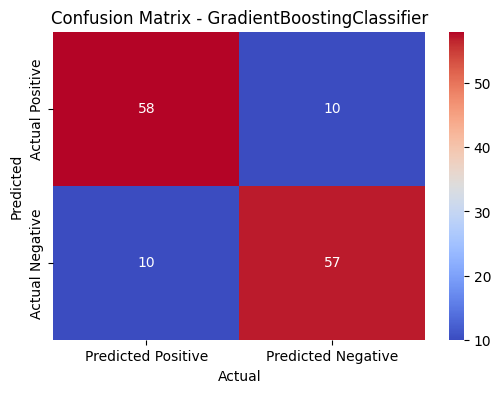

----------------------------------------------------------------------
model:  RandomForestClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        68
           1       0.83      0.87      0.85        67

    accuracy                           0.84       135
   macro avg       0.85      0.84      0.84       135
weighted avg       0.85      0.84      0.84       135



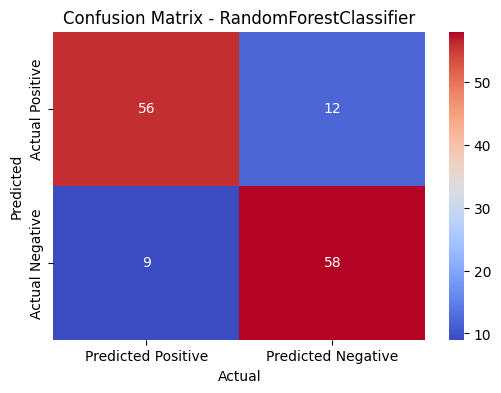

----------------------------------------------------------------------


In [52]:
metrics = []

# Iterating over models 
for model in final_models_finetuned:
    # Create a pipeline containing the preprocesor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)

    # Predict using the evaluation set
    y_pred = pipeline.predict(X_eval)

    # print classification report
    print('model: ', model.__class__.__name__)
    print('Classification Report: \n', classification_report(y_eval_encoded, y_pred))

    #Generate and display confusion matrix
    conf_matrix = confusion_matrix(y_eval_encoded, y_pred)

        # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', 
                xticklabels=['Predicted Positive', 'Predicted Negative'], 
                yticklabels=['Actual Positive', 'Actual Negative'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

    print('--'*35)

Export Key Components

We export the important ML objects that will be used to develop an app: encoder and pipeline.

In [53]:
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', final_models_finetuned[0])
    ])

In [54]:
components= {
    'pipeline': pipeline,
    'encoder': encoder,
}

Saving best Model

In [55]:
#path to the destination directory
destination = "..\model"

# Construct the full file path
file_path = os.path.join(destination, "ml.pkl")

# Save the components object as a pickled file
with open(file_path, "wb") as f:
    pickle.dump(components, f)